In [1]:
import itertools
from collections import OrderedDict

import numpy as np
import scipy as sp
import pandas as pd

import matplotlib as mplib
import matplotlib.pyplot as plt

import ipywidgets as widgets

In [2]:
%matplotlib notebook

In [3]:
from IPython.display import HTML

HTML('''<script>
code_show=false; 
function code_toggle()
{
    if (code_show)
    {
        $('div.input').hide();
    }
    else
    {
        $('div.input').show();
    }
    code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook can be hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [4]:
# Maybe experiment with more direct connections?
# from ftplib import FTP

# Table of Contents
* [Read base table](#Read-base-table)
* [Make UTC Time data](#Make-UTC-Time-data)
* [Parse BAT data](#Parse-BAT-data)
    * [Photon Index](#Photon-Index)
    * [$T_{90}$](#$T_{90}$)
* [Process coordinate columns](#Process-coordinate-columns)
* [Parse UVOT data](#Parse-UVOT-data)
    * [Read raw data](#Read-raw-data)
    * [Process UVOT data to 'lohi' columns](#Process-UVOT-data-to-'lohi'-columns)
* [Process Redshift data](#Process-Redshift-data)
* [Save full data table](#Save-full-data-table)
* [Preliminary analysis](#Preliminary-analysis)
    * [BAT data](#BAT-data)
    * [XRT data](#XRT-data)
    * [Color indices from UVOT data](#Color-indices-from-UVOT-data)
* [Final formatting](#Final-formatting)
    * [Tab delimited text save](#Tab-delimited-text-save)
    * [SQLite3 database save](#SQLite3-database-save)
    * [Pickle save](#Pickle-save)

# Read base table

The file `grb_table_1524584294.txt` was acquired via the website https://swift.gsfc.nasa.gov/archive/grb_table/, by restricting the output to 'results with redshifts' and querying every column, then converting the file encoding to UTF-8.

Further error corrections were carried out during processing, such as replacing missing separators, etc.

In [5]:
df = pd.read_csv('raw_data/grb_table_1524584294_corr.txt',sep='\t',header=(0))

In [6]:
df

,GRB,Time [UT],Trigger Number,BAT RA (J2000),BAT Dec (J2000),BAT 90% Error Radius [arcmin],BAT T90 [sec],BAT Fluence (15-150 keV) [10^-7 erg/cm^2],BAT Fluence 90% Error (15-150 keV) [10^-7 erg/cm^2],BAT 1-sec Peak Photon Flux (15-150 keV) [ph/cm^2/sec],...,UVOT 90% Error Radius [arcsec],UVOT Time to First Observation [sec],UVOT Magnitude,UVOT Other Filter Magnitudes,Other Observatory Detections,Redshift,Host Galaxy,Comments,References,Burst Advocate
0,180404A,00:45:35,821881,83.540,-37.168,1.1,35.2,13.00,1.00,1.30,...,0.50,90.0,V>18.9,B>19.4|U=18.95|UVW1>17.8|UVM2>17.4|UVW2=19.45|...,"VLT, MASTER-OAFA, Faulkes South (2m)",1.000 (VLT: absorption),NaN,NaN,NaN,Jeff Gropp
1,180329B,14:08:23,819490,82.905,-23.694,1.8,210.0,33.00,3.00,1.40,...,0.43,113.0,V=17.25,B=17.94|U=17.00|UVW1=18.72|UVM2>19.8|UVW2>20.2...,"NOT, HJT (1.5m), VLT, Faulks South (2m)",1.998 (VLT: absorption),NaN,NaN,NaN,Judy Racusin
2,180325A,01:53:02,817564,157.416,24.461,1.1,94.1,65.00,2.00,9.40,...,0.44,82.0,V>18.8,B>20.1|U>20.0|UVW1>20.1|UVM2>19.4|UVW2>20.9|Wh...,"Liverpool (2m), NOT (2.5m), REM (60cm), HJT (1...",2.25 (NOT: absorption)| 2.248 (VLT: absorption),NaN,NaN,NaN,Eleonora Troja
3,180314A,00:43:31,814129,99.208,-24.530,3.1,51.2,110.00,4.00,7.90,...,0.42,167.0,V=17.07,B=18.09|U=16.95|UVW1=17.98|UVM2=18.12|UVW2=18....,"MPG (2.2m), MASTER-IAC, MASTER-OAFA, REM (60cm...",1.445 (VLT: absorption),NaN,NaN,NaN,Paolo D'Avanzo
4,180205A,04:25:29.3,808625,126.819,11.536,1.1,15.5,10.00,1.00,3.40,...,0.42,182.0,V=16.11,B=16.65|U=16.82|UVW1=16.04|UVM2=16.32|UVW2=17....,"KAIT (0.76m), MPG (2.2m), VLT, Fermi (GBM), Sa...",1.409 (VLT: absorption),NaN,NaN,NaN,Phil Evans
5,180115A,04:16:03,805318,12.040,-15.632,1.8,40.9,7.60,1.10,0.60,...,0.43,140.0,V=16.50,B=16.93|U=16.32|UVW1>20.7|UVM2>21.8|UVW2>20.2|...,"NOT (2.5m), GTC (1.4m), Palomar (60"")",2.487 (GTC),NaN,NaN,NaN,John Cannizzo
6,171222A,16:24:59,799669,148.273,35.624,1.7,174.8,19.00,2.00,0.70,...,NaN,176.0,V>19.2,U>20.3|B>20.3|UVW1>19.4|UVM2>19.3|UVW2>19.6,"NOT, GTC (10.4m), MASTER-Net, Nanshan (1m), Fe...",2.409 (GTC: absorption),NaN,UVOT: no detection,NaN,Judith Racusin
7,171205A,07:20:43,794972,167.423,-12.599,1.6,189.4,36.00,3.00,1.00,...,NaN,154.0,V= 18.22,U=17.78|B=18.45|UVW1=17.13|UVM2=17.11|UVW2=16....,"VLT, HJT (1.5m), GMG (2.4m), NOEMA @ 150GHz, L...",0.0368 (VLT: emission & absorption),Likely host: 2MASX J11093966-1235116 (z = 0.037),NaN,NaN,Valerio D'Elia
8,171020A,23:07:10,780845,39.260,15.199,1.8,41.9,12.00,1.00,0.70,...,NaN,147.0,V>19.4,B>20.8|U>20.2|UVW1>20.7|UVM2>20.3|UVW2>20.3|Wh...,"NOT, SAO RAS (1.0m), Liverpool (2m), HJT (1.5m...",1.87 (NOT: absorption),NaN,NaN,NaN,Kim Page
9,170903A,12:49:07,770528,254.532,34.985,1.3,29.2,24.00,2.00,3.90,...,NaN,3484.0,V>1.7,B>20.5|U>21.0|UVW1>20.7|UVM2>20.4|UVW2>21.8|Wh...,Fermi (GBM),0.886 (GTC: emission from host),i-band (AB) = 23.17 (GTC),"Due to an observing constraint, Swift did not ...",NaN,Craig Markwardt


In [7]:
colnames = list(df.columns.values)

colnames

['GRB',
 'Time [UT]',
 'Trigger Number',
 'BAT RA (J2000)',
 'BAT Dec (J2000)',
 'BAT 90% Error Radius [arcmin]',
 'BAT T90 [sec]',
 'BAT Fluence (15-150 keV) [10^-7 erg/cm^2]',
 'BAT Fluence 90% Error (15-150 keV) [10^-7 erg/cm^2]',
 'BAT 1-sec Peak Photon Flux (15-150 keV) [ph/cm^2/sec]',
 'BAT 1-sec Peak Photon Flux 90% Error (15-150 keV) [ph/cm^2/sec]',
 'BAT Photon Index (15-150 keV) (PL = simple power-law, CPL = cutoff power-law)',
 'BAT Photon Index 90% Error (15-150 keV)',
 'XRT RA (J2000)',
 'XRT Dec (J2000)',
 'XRT 90% Error Radius [arcsec]',
 'XRT Time to First Observation [sec]',
 'XRT Early Flux (0.3-10 keV) [10^-11 erg/cm^2/s]',
 'XRT 11 Hour Flux (0.3-10 keV) [10^-11 erg/cm^2/s]',
 'XRT 24 Hour Flux (0.3-10 keV) [10^-11 erg/cm^2/s]',
 'XRT Initial Temporal Index',
 'XRT Spectral Index (Gamma)',
 'XRT Column Density (NH) [10^21 cm^-2]',
 'UVOT RA (J2000)',
 'UVOT Dec (J2000)',
 'UVOT 90% Error Radius [arcsec]',
 'UVOT Time to First Observation [sec]',
 'UVOT Magnitude',
 

Generate more manageable column names

In [8]:
colnames2 = []

for n in colnames:
    newname = n.split('[')[0].strip() # Trim units
    newname = newname.replace('.','d').replace('-','_') # Replace invalid characters
    newname = newname.replace('%','pc')
    newname = newname.replace('(','',1).replace(')','',1) # Allow 1 bracketed phrase past
    newname = newname.split('(')[0] # But no more
    newname = newname.strip().replace(' ','_') # Replace spaces too
    colnames2.append(newname) 

colnames2

['GRB',
 'Time',
 'Trigger_Number',
 'BAT_RA_J2000',
 'BAT_Dec_J2000',
 'BAT_90pc_Error_Radius',
 'BAT_T90',
 'BAT_Fluence_15_150_keV',
 'BAT_Fluence_90pc_Error_15_150_keV',
 'BAT_1_sec_Peak_Photon_Flux_15_150_keV',
 'BAT_1_sec_Peak_Photon_Flux_90pc_Error_15_150_keV',
 'BAT_Photon_Index_15_150_keV',
 'BAT_Photon_Index_90pc_Error_15_150_keV',
 'XRT_RA_J2000',
 'XRT_Dec_J2000',
 'XRT_90pc_Error_Radius',
 'XRT_Time_to_First_Observation',
 'XRT_Early_Flux_0d3_10_keV',
 'XRT_11_Hour_Flux_0d3_10_keV',
 'XRT_24_Hour_Flux_0d3_10_keV',
 'XRT_Initial_Temporal_Index',
 'XRT_Spectral_Index_Gamma',
 'XRT_Column_Density_NH',
 'UVOT_RA_J2000',
 'UVOT_Dec_J2000',
 'UVOT_90pc_Error_Radius',
 'UVOT_Time_to_First_Observation',
 'UVOT_Magnitude',
 'UVOT_Other_Filter_Magnitudes',
 'Other_Observatory_Detections',
 'Redshift',
 'Host_Galaxy',
 'Comments',
 'References',
 'Burst_Advocate']

In [9]:
colnameMap=dict(zip(colnames, colnames2))

df.rename(colnameMap,axis='columns',inplace=True)

In [10]:
df

,GRB,Time,Trigger_Number,BAT_RA_J2000,BAT_Dec_J2000,BAT_90pc_Error_Radius,BAT_T90,BAT_Fluence_15_150_keV,BAT_Fluence_90pc_Error_15_150_keV,BAT_1_sec_Peak_Photon_Flux_15_150_keV,...,UVOT_90pc_Error_Radius,UVOT_Time_to_First_Observation,UVOT_Magnitude,UVOT_Other_Filter_Magnitudes,Other_Observatory_Detections,Redshift,Host_Galaxy,Comments,References,Burst_Advocate
0,180404A,00:45:35,821881,83.540,-37.168,1.1,35.2,13.00,1.00,1.30,...,0.50,90.0,V>18.9,B>19.4|U=18.95|UVW1>17.8|UVM2>17.4|UVW2=19.45|...,"VLT, MASTER-OAFA, Faulkes South (2m)",1.000 (VLT: absorption),NaN,NaN,NaN,Jeff Gropp
1,180329B,14:08:23,819490,82.905,-23.694,1.8,210.0,33.00,3.00,1.40,...,0.43,113.0,V=17.25,B=17.94|U=17.00|UVW1=18.72|UVM2>19.8|UVW2>20.2...,"NOT, HJT (1.5m), VLT, Faulks South (2m)",1.998 (VLT: absorption),NaN,NaN,NaN,Judy Racusin
2,180325A,01:53:02,817564,157.416,24.461,1.1,94.1,65.00,2.00,9.40,...,0.44,82.0,V>18.8,B>20.1|U>20.0|UVW1>20.1|UVM2>19.4|UVW2>20.9|Wh...,"Liverpool (2m), NOT (2.5m), REM (60cm), HJT (1...",2.25 (NOT: absorption)| 2.248 (VLT: absorption),NaN,NaN,NaN,Eleonora Troja
3,180314A,00:43:31,814129,99.208,-24.530,3.1,51.2,110.00,4.00,7.90,...,0.42,167.0,V=17.07,B=18.09|U=16.95|UVW1=17.98|UVM2=18.12|UVW2=18....,"MPG (2.2m), MASTER-IAC, MASTER-OAFA, REM (60cm...",1.445 (VLT: absorption),NaN,NaN,NaN,Paolo D'Avanzo
4,180205A,04:25:29.3,808625,126.819,11.536,1.1,15.5,10.00,1.00,3.40,...,0.42,182.0,V=16.11,B=16.65|U=16.82|UVW1=16.04|UVM2=16.32|UVW2=17....,"KAIT (0.76m), MPG (2.2m), VLT, Fermi (GBM), Sa...",1.409 (VLT: absorption),NaN,NaN,NaN,Phil Evans
5,180115A,04:16:03,805318,12.040,-15.632,1.8,40.9,7.60,1.10,0.60,...,0.43,140.0,V=16.50,B=16.93|U=16.32|UVW1>20.7|UVM2>21.8|UVW2>20.2|...,"NOT (2.5m), GTC (1.4m), Palomar (60"")",2.487 (GTC),NaN,NaN,NaN,John Cannizzo
6,171222A,16:24:59,799669,148.273,35.624,1.7,174.8,19.00,2.00,0.70,...,NaN,176.0,V>19.2,U>20.3|B>20.3|UVW1>19.4|UVM2>19.3|UVW2>19.6,"NOT, GTC (10.4m), MASTER-Net, Nanshan (1m), Fe...",2.409 (GTC: absorption),NaN,UVOT: no detection,NaN,Judith Racusin
7,171205A,07:20:43,794972,167.423,-12.599,1.6,189.4,36.00,3.00,1.00,...,NaN,154.0,V= 18.22,U=17.78|B=18.45|UVW1=17.13|UVM2=17.11|UVW2=16....,"VLT, HJT (1.5m), GMG (2.4m), NOEMA @ 150GHz, L...",0.0368 (VLT: emission & absorption),Likely host: 2MASX J11093966-1235116 (z = 0.037),NaN,NaN,Valerio D'Elia
8,171020A,23:07:10,780845,39.260,15.199,1.8,41.9,12.00,1.00,0.70,...,NaN,147.0,V>19.4,B>20.8|U>20.2|UVW1>20.7|UVM2>20.3|UVW2>20.3|Wh...,"NOT, SAO RAS (1.0m), Liverpool (2m), HJT (1.5m...",1.87 (NOT: absorption),NaN,NaN,NaN,Kim Page
9,170903A,12:49:07,770528,254.532,34.985,1.3,29.2,24.00,2.00,3.90,...,NaN,3484.0,V>1.7,B>20.5|U>21.0|UVW1>20.7|UVM2>20.4|UVW2>21.8|Wh...,Fermi (GBM),0.886 (GTC: emission from host),i-band (AB) = 23.17 (GTC),"Due to an observing constraint, Swift did not ...",NaN,Craig Markwardt


# Make UTC Time data
Convert GRB label and time to UTC epoch time, for efficient storage later.

In [11]:
time_df = pd.DataFrame({
    'UTC_Time'
    :
    (
        df['GRB'].apply(
            lambda x:
            '20' + x[:2] + '-' + x[2:4] + '-' + x[4:6]
        )
        +
        df['Time'].apply(
            lambda x:
            'T'+x
        )
    ).apply(
        lambda x:
        np.int64(np.datetime64(x, 'ms'))
    )
})

In [12]:
time_df

,UTC_Time
0,1522802735000
1,1522332503000
2,1521942782000
3,1520988211000
4,1517804729300
5,1515989763000
6,1513959899000
7,1512458443000
8,1508540830000
9,1504442947000


# Parse BAT data

## Photon Index

In [13]:
def nan_array_of_len(df):
    return np.full(len(df),np.nan,dtype=object)

In [14]:
bat_ph_idx_df = pd.DataFrame(OrderedDict([
    ('bat_photon_index_value',nan_array_of_len(df)),
    ('bat_photon_index_model',nan_array_of_len(df)),
    ('bat_photon_index_model_idx',nan_array_of_len(df)),
    ('bat_photon_index_error_min',nan_array_of_len(df)),
    ('bat_photon_index_error_max',nan_array_of_len(df))
]))

In [15]:
bat_ph_idx_colname = colnames2[11]
bat_ph_idx_err_colname = colnames2[12]

In [16]:
for row in df.iterrows():
    idx = row[0]
    data = row[1]
    
    bat_data = data[bat_ph_idx_colname]
    
    if type(bat_data) == str:
        bat_data_split = bat_data.split(',')
        
        if len(bat_data_split) == 1:
            bat_data_split = bat_data.replace(')','').split('(')
            
        bat_ph_idx_df['bat_photon_index_value'][idx] = np.float(bat_data_split[0])
        bat_ph_idx_df['bat_photon_index_model_idx'][idx] = None
        if len(bat_data_split) > 1:
            bat_model = bat_data_split[1].strip()
            bat_ph_idx_df['bat_photon_index_model'][idx] = bat_model
            if bat_model == 'PL':
                bat_ph_idx_df['bat_photon_index_model_idx'][idx] = 0
            elif bat_model == 'CPL':
                bat_ph_idx_df['bat_photon_index_model_idx'][idx] = 1
    else:
        bat_ph_idx_df['bat_photon_index_value'][idx] = bat_data
        bat_ph_idx_df['bat_photon_index_model_idx'][idx] = 0
    
    bat_err = data[bat_ph_idx_err_colname]
    
    if type(bat_err) == str:
        bat_err_split = bat_err.split('/')
        bat_err_nums = list(map(float,bat_err_split))
        bat_ph_idx_df['bat_photon_index_error_min'][idx] = min(bat_err_nums)
        bat_ph_idx_df['bat_photon_index_error_max'][idx] = max(bat_err_nums)
    else:
        bat_ph_idx_df['bat_photon_index_error_min'][idx] = bat_err
        bat_ph_idx_df['bat_photon_index_error_max'][idx] = bat_err

## $T_{90}$

In [17]:
bat_t90_colname = colnames2[6]

In [18]:
bat_t90_df = pd.DataFrame(OrderedDict([
    ('t90_lo', nan_array_of_len(df)),
    ('t90_hi', nan_array_of_len(df))
]))

In [19]:
for row in df.iterrows():
    idx = row[0]
    data = row[1]
    
    bat_t90_data = data[bat_t90_colname]
    
    if type(bat_t90_data) == str:
        bat_t90_data = bat_t90_data.replace('~','').strip()
        
        if bat_t90_data[0] == '>':
            bat_t90_val = np.float(bat_t90_data[1:])
            bat_t90_df['t90_lo'][idx] = bat_t90_val
        else:
            bat_t90_val = np.float(bat_t90_data)
            bat_t90_df['t90_lo'][idx] = bat_t90_val
            bat_t90_df['t90_hi'][idx] = bat_t90_val
    else:
        bat_t90_df['t90_lo'][idx] = bat_t90_data
        bat_t90_df['t90_hi'][idx] = bat_t90_data

# Process coordinate columns
Just to be sure that its the same source that's being measured by different instruments

In [20]:
ra_colnames = [colnames2[13],colnames2[23]]
dec_colnames = [colnames2[14],colnames2[24]]

In [21]:
coord_df = pd.DataFrame(OrderedDict([
    ('xrt_ra', nan_array_of_len(df)),
    ('xrt_dec', nan_array_of_len(df)),
    ('uvot_ra', nan_array_of_len(df)),
    ('uvot_dec', nan_array_of_len(df))
]))

In [22]:
ra = 12
( ra )/12*180

180.0

In [23]:
def hms_to_float(hms_str):
    if type(hms_str) == str:
        hms_split = hms_str.split(':')
        hms_value = np.float(hms_split[0]) + np.float(hms_split[1])/60 + np.float(hms_split[1])/3600
        return hms_value
    else:
        return np.nan

In [24]:
for row in df.iterrows():
    idx = row[0]
    data = row[1]
    
    coord_df['xrt_ra'][idx] = hms_to_float(data[colnames2[13]])/12*180
    coord_df['xrt_dec'][idx] = hms_to_float(data[colnames2[14]])
    coord_df['uvot_ra'][idx] = hms_to_float(data[colnames2[23]])/12*180
    coord_df['uvot_dec'][idx] = hms_to_float(data[colnames2[24]])

# Parse UVOT data
## Read raw data

In [25]:
uvot_v_colName = colnames2[27]
uvot_rest_colName = colnames2[28]

print(uvot_v_colName)
print(uvot_rest_colName)

UVOT_Magnitude
UVOT_Other_Filter_Magnitudes


In [26]:
def try_partitioning(text, charlist):
    for c in charlist:
        parted = text.partition(c)
        if(parted[1] != ''):
            return parted
    return parted

After reviewing the initial subtable the following misspellings were found in the data:

In [27]:
colName_misspells = {
    'UWM2':'UVM2',
    'UWW2':'UVW2',
    'IVW2':'UVW2',
    'UV1W':'UVW1',
    'IVW1':'UVW1',
    'UW2':'UVW2'
}

In [28]:
def clean_colname(dirtycolname):
    cleaner_colname = dirtycolname.strip().upper().replace('-','_')
    if cleaner_colname in colName_misspells:
        return colName_misspells[cleaner_colname]
    else:
        return cleaner_colname

In [29]:
uvot_subColSeps = '>=?+<'

In [30]:
# Misspelled column name UVW requires special treatment
def uvw_misspell_mapping(idx):
    if idx == 91:
        return 'UVW1'
    if idx == 246:
        return 'UVW2'
    if idx == 252:
        return 'UVW1'
    if idx == 313:
        return None #Cannot correct row, insufficient data

In [31]:
def filter_inner_column_names_and_preallocate_dict(dc, df_col):
    for item in df_col:
        if type(item) == str:
            strlist = item.split('|')
            for subitem in strlist:
                parted = try_partitioning(subitem, uvot_subColSeps)
                cleaned_colname = clean_colname(parted[0])
                if cleaned_colname != 'UVW':
                    dc[cleaned_colname] = nan_array_of_len(df)

In [32]:
uvot_table_columns = OrderedDict()

In [33]:
filter_inner_column_names_and_preallocate_dict(uvot_table_columns,df[uvot_v_colName])
filter_inner_column_names_and_preallocate_dict(uvot_table_columns,df[uvot_rest_colName])

In [34]:
list(uvot_table_columns.keys())

['V', 'B', 'U', 'UVW1', 'UVM2', 'UVW2', 'WHITE', 'WHITE_FC', 'U_FC']

In [35]:
uvot_df = pd.DataFrame(uvot_table_columns)

In [36]:
for row in df.iterrows():
    idx = row[0]
    data = row[1]
    
    v_data = data[uvot_v_colName]
    
    if type(v_data) == str:
        v_parted = try_partitioning(v_data,uvot_subColSeps)
        uvot_df[clean_colname(v_parted[0])][idx] = ''.join(v_parted[1:])
    
    
    rest_data = data[uvot_rest_colName]
    
    if type(rest_data) == str:
        for subitem in rest_data.split('|'):
            c_parted = try_partitioning(subitem,uvot_subColSeps)
            cleaned_colname = clean_colname(c_parted[0])
            # Misspelled column name UVW requires special treatment
            if cleaned_colname == 'UVW':
                cleaned_colname = uvw_misspell_mapping(idx)
            if cleaned_colname != None:
                uvot_df[cleaned_colname][idx] = ''.join(c_parted[1:])

In [37]:
uvot_df

,V,B,U,UVW1,UVM2,UVW2,WHITE,WHITE_FC,U_FC
0,>18.9,>19.4,=18.95,>17.8,>17.4,=19.45,=19.34,NaN,NaN
1,=17.25,=17.94,=17.00,=18.72,>19.8,>20.2,=17.69,NaN,NaN
2,>18.8,>20.1,>20.0,>20.1,>19.4,>20.9,=18.48,NaN,NaN
3,=17.07,=18.09,=16.95,=17.98,=18.12,=18.75,=17.86,NaN,NaN
4,=16.11,=16.65,=16.82,=16.04,=16.32,=17.06,=16.33,NaN,NaN
5,=16.50,=16.93,=16.32,>20.7,>21.8,>20.2,=17.61,NaN,NaN
6,>19.2,>20.3,>20.3,>19.4,>19.3,>19.6,NaN,NaN,NaN
7,= 18.22,=18.45,=17.78,=17.13,=17.11,=16.96,=17.70,NaN,NaN
8,>19.4,>20.8,>20.2,>20.7,>20.3,>20.3,>21.4,NaN,NaN
9,>1.7,>20.5,>21.0,>20.7,>20.4,>21.8,>21.6,NaN,NaN


In [38]:
with open('temporary_data/uvot.txt','w') as uvot_file:
    uvot_df.to_csv(uvot_file,sep='\t',na_rep='n/a')

## Process UVOT data to 'lohi' columns
Make numeric data from '<=>' data by declaring lo-hi fields. '=' fields will have equal lo-hi fields, '>' ones will have only lo fields, etc.

In [39]:
uvot_columnNames=list(uvot_table_columns.keys())

In [40]:
uvot_lohi_columnNames = list(sum(list(zip(map(lambda colname: colname+'_lo', uvot_columnNames), map(lambda colname: colname+'_hi', uvot_columnNames))),()))

In [41]:
uvot_lohi_table = OrderedDict(
    zip(uvot_lohi_columnNames, [nan_array_of_len(df)] * len(uvot_lohi_columnNames))
)

In [42]:
uvot_lohi_df = pd.DataFrame(uvot_lohi_table)

In [43]:
for row in uvot_df.iterrows():
    idx = row[0]
    data = row[1]
    
    for colIdx in range(len(data)):
        colName = data.index[colIdx]
        colData = data[colIdx]
        
        if type(colData) == str:
            colData = colData.strip()
            if colData[0] == '>':
                uvot_lohi_df[colName+'_lo'][idx] = np.float(colData[1:])
            elif colData[0] == '<':
                uvot_lohi_df[colName+'_hi'][idx] = np.float(colData[1:])
            elif colData[0] == '=':
                splitData = colData[1:].split('(')
                if len(splitData) > 1:
                    meanData = np.float(splitData[0].strip())
                    sigData = np.float(splitData[1].split('sigma')[0].strip())
                    uvot_lohi_df[colName+'_lo'][idx] = meanData - sigData
                    uvot_lohi_df[colName+'_hi'][idx] = meanData + sigData
                    continue
                
                splitData = colData[1:].split('-')
                if len(splitData) > 1:
                    floatData = list(map(np.float, splitData))
                    uvot_lohi_df[colName+'_lo'][idx] = min(floatData)
                    uvot_lohi_df[colName+'_hi'][idx] = max(floatData)
                    continue
                    
                uvot_lohi_df[colName+'_lo'][idx] = np.float(colData[1:])
                uvot_lohi_df[colName+'_hi'][idx] = np.float(colData[1:])

In [44]:
uvot_lohi_df

,V_lo,V_hi,B_lo,B_hi,U_lo,U_hi,UVW1_lo,UVW1_hi,UVM2_lo,UVM2_hi,UVW2_lo,UVW2_hi,WHITE_lo,WHITE_hi,WHITE_FC_lo,WHITE_FC_hi,U_FC_lo,U_FC_hi
0,18.9,NaN,19.4,NaN,18.95,18.95,17.8,NaN,17.4,NaN,19.45,19.45,19.34,19.34,NaN,NaN,NaN,NaN
1,17.25,17.25,17.94,17.94,17,17,18.72,18.72,19.8,NaN,20.2,NaN,17.69,17.69,NaN,NaN,NaN,NaN
2,18.8,NaN,20.1,NaN,20,NaN,20.1,NaN,19.4,NaN,20.9,NaN,18.48,18.48,NaN,NaN,NaN,NaN
3,17.07,17.07,18.09,18.09,16.95,16.95,17.98,17.98,18.12,18.12,18.75,18.75,17.86,17.86,NaN,NaN,NaN,NaN
4,16.11,16.11,16.65,16.65,16.82,16.82,16.04,16.04,16.32,16.32,17.06,17.06,16.33,16.33,NaN,NaN,NaN,NaN
5,16.5,16.5,16.93,16.93,16.32,16.32,20.7,NaN,21.8,NaN,20.2,NaN,17.61,17.61,NaN,NaN,NaN,NaN
6,19.2,NaN,20.3,NaN,20.3,NaN,19.4,NaN,19.3,NaN,19.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,18.22,18.22,18.45,18.45,17.78,17.78,17.13,17.13,17.11,17.11,16.96,16.96,17.7,17.7,NaN,NaN,NaN,NaN
8,19.4,NaN,20.8,NaN,20.2,NaN,20.7,NaN,20.3,NaN,20.3,NaN,21.4,NaN,NaN,NaN,NaN,NaN
9,1.7,NaN,20.5,NaN,21,NaN,20.7,NaN,20.4,NaN,21.8,NaN,21.6,NaN,NaN,NaN,NaN,NaN


In [45]:
with open('temporary_data/uvot_lohi.txt','w') as uvot_lohi_file:
    uvot_lohi_df.to_csv(uvot_lohi_file,sep='\t',na_rep='n/a')

In [46]:
redshift_columns = OrderedDict([
    ('z', nan_array_of_len(df)),
    ('z_std', nan_array_of_len(df))
])

# Process Redshift data

In [47]:
redshift_df = pd.DataFrame(redshift_columns)

In [48]:
redshift_colName = colnames2[30]

In [49]:
for row in df.iterrows():
    idx = row[0]
    data = row[1]
    
    z_data = data[redshift_colName]
    
    z_list = np.array([], dtype=np.float)
    
    z_mean = np.nan
    z_std = np.nan
    
    if type(z_data) == str:
        for subitem in z_data.split('|'):
            this_z_str = subitem.replace('{','(').split('(')[0].strip().replace('~','') # '~' characters are completely unnecessarily used
            
            if this_z_str[0] == '<':
                split_by_decimal = this_z_str.split('.')
                if len(split_by_decimal) > 1:
                    this_z_str = this_z_str[1:] # If the data point is precise to a decimal, then the real value is probably near
                else:
                    this_z_str = '0 < z ' + this_z_str # no lower redshift possible
            
            this_z_str_split_try = this_z_str.split('< z <')
            if len(this_z_str_split_try) > 1:
                for sub_z in this_z_str_split_try:
                    z_list = np.append(z_list,np.float(sub_z))
                continue
            
            if this_z_str[0] == '>':
                split_by_decimal = this_z_str.split('.')
                if len(split_by_decimal) > 1:
                    this_z_str = this_z_str[1:] # If the data point is precise to a decimal, then the real value is probably near (for the purposes of NN training)
                else:
                    this_z_str = 'inf > z ' + this_z_str # no higher redshift possible
            
            this_z_str_split_try = this_z_str.split('> z >')
            if len(this_z_str_split_try) > 1:
                for sub_z in this_z_str_split_try:
                    z_list = np.append(z_list,np.float(sub_z))
                continue
            
            this_z_str_split_try = this_z_str.split(' or ')
            if len(this_z_str_split_try) > 1:
                for sub_z in this_z_str_split_try:
                    z_list = np.append(z_list,np.float(sub_z))
                continue
            
            z_list = np.append(z_list,np.float(this_z_str.strip().split(' ')[0]))
        
        z_mean = np.mean(z_list)
        z_std = np.std(z_list)
        # This is a population STD, because we wish to select optimally defined z values for training
        # In this case the various z values for a given GRB are a population
        # It's also nice that single data points have an std of 0 in this case
        
        redshift_df['z'][idx] = z_mean
        redshift_df['z_std'][idx] = z_std

In [50]:
redshift_df

,z,z_std
0,1,0
1,1.998,0
2,2.249,0.001
3,1.445,0
4,1.409,0
5,2.487,0
6,2.409,0
7,0.0368,0
8,1.87,0
9,0.886,0


In [51]:
with open('temporary_data/redshift.txt','w') as redshift_file:
    redshift_df.to_csv(redshift_file,sep='\t',na_rep='n/a')

# Save full data table

In [52]:
full_df = df.join(time_df).join(coord_df).join(bat_t90_df).join(bat_ph_idx_df).join(uvot_lohi_df).join(redshift_df)

In [53]:
full_df

,GRB,Time,Trigger_Number,BAT_RA_J2000,BAT_Dec_J2000,BAT_90pc_Error_Radius,BAT_T90,BAT_Fluence_15_150_keV,BAT_Fluence_90pc_Error_15_150_keV,BAT_1_sec_Peak_Photon_Flux_15_150_keV,...,UVW2_lo,UVW2_hi,WHITE_lo,WHITE_hi,WHITE_FC_lo,WHITE_FC_hi,U_FC_lo,U_FC_hi,z,z_std
0,180404A,00:45:35,821881,83.540,-37.168,1.1,35.2,13.00,1.00,1.30,...,19.45,19.45,19.34,19.34,NaN,NaN,NaN,NaN,1,0
1,180329B,14:08:23,819490,82.905,-23.694,1.8,210.0,33.00,3.00,1.40,...,20.2,NaN,17.69,17.69,NaN,NaN,NaN,NaN,1.998,0
2,180325A,01:53:02,817564,157.416,24.461,1.1,94.1,65.00,2.00,9.40,...,20.9,NaN,18.48,18.48,NaN,NaN,NaN,NaN,2.249,0.001
3,180314A,00:43:31,814129,99.208,-24.530,3.1,51.2,110.00,4.00,7.90,...,18.75,18.75,17.86,17.86,NaN,NaN,NaN,NaN,1.445,0
4,180205A,04:25:29.3,808625,126.819,11.536,1.1,15.5,10.00,1.00,3.40,...,17.06,17.06,16.33,16.33,NaN,NaN,NaN,NaN,1.409,0
5,180115A,04:16:03,805318,12.040,-15.632,1.8,40.9,7.60,1.10,0.60,...,20.2,NaN,17.61,17.61,NaN,NaN,NaN,NaN,2.487,0
6,171222A,16:24:59,799669,148.273,35.624,1.7,174.8,19.00,2.00,0.70,...,19.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.409,0
7,171205A,07:20:43,794972,167.423,-12.599,1.6,189.4,36.00,3.00,1.00,...,16.96,16.96,17.7,17.7,NaN,NaN,NaN,NaN,0.0368,0
8,171020A,23:07:10,780845,39.260,15.199,1.8,41.9,12.00,1.00,0.70,...,20.3,NaN,21.4,NaN,NaN,NaN,NaN,NaN,1.87,0
9,170903A,12:49:07,770528,254.532,34.985,1.3,29.2,24.00,2.00,3.90,...,21.8,NaN,21.6,NaN,NaN,NaN,NaN,NaN,0.886,0


In [54]:
with open('temporary_data/full.txt','w') as full_file:
    full_df.to_csv(full_file,sep='\t',na_rep='')

# Preliminary analysis

## BAT data

In [55]:
bat_column_map = {
    'T90' : (full_df['t90_lo']+full_df['t90_hi'])/2,
    'Fluence' : full_df[['BAT_Fluence_15_150_keV', 'BAT_Fluence_90pc_Error_15_150_keV']],
    'Peak Flux' : full_df[['BAT_1_sec_Peak_Photon_Flux_15_150_keV', 'BAT_1_sec_Peak_Photon_Flux_90pc_Error_15_150_keV']],
    'Photon Index' : full_df[['bat_photon_index_value', 'bat_photon_index_error_min', 'bat_photon_index_error_max']],
    'Redshift' : full_df[['z', 'z_std']]
}

In [56]:
pd.isna(None)

True

In [57]:
bat_photon_index_model_map = {
    'PL' : lambda x: x == 0,
    'CPL' : lambda x: x == 1,
    'n/a' : lambda x: pd.isna(x)
}

In [58]:
bat_column_selection = list(bat_column_map.keys())

bat_model_selection = list(bat_photon_index_model_map.keys())

In [59]:
def combine_model_selection(model_list, data):
    ans = np.full(data.shape,False)
    for name in model_list:
        ans = np.logical_or(ans, bat_photon_index_model_map[name](data))
    return ans

<IPython.core.display.Javascript object>


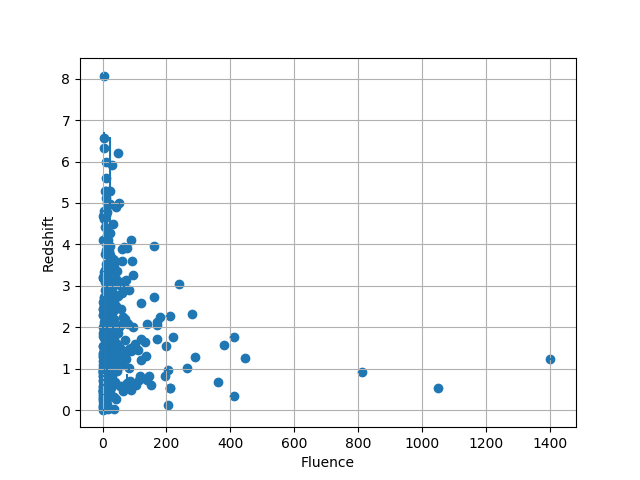

In [60]:
bat_fig, bat_axes = plt.subplots(num='BAT data inspection')
def bat_demo(column1, column2, models, ommitIndices):
    df1 = bat_column_map[column1]
    df2 = bat_column_map[column2]
    
    if type(df1) == pd.Series:
        width1 = 1
    else:
        width1 = len(df1.columns)
        
    if type(df2) == pd.Series:
        width2 = 1
    else:
        width2 = len(df2.columns)
    
    data_matrix = np.append(
        np.append(
            np.reshape(
                full_df['bat_photon_index_model_idx'].values,
                (len(full_df),1)
            ),
            np.reshape(
                df1.values,
                (len(full_df),width1)
            ),
            axis=1
        ).astype(np.float),
        np.reshape(
            df2.values,
            (len(full_df),width2)
        ),
        axis=1
    ).astype(np.float)
    data_matrix = np.delete(data_matrix, ommitIndices, 0) 
    data_matrix_nonan = data_matrix[~np.isnan(data_matrix[:,(1,width1+1)]).any(axis=1)]
    data_matrix_nonan = data_matrix_nonan[combine_model_selection(models,data_matrix_nonan[:,0])]
    data_matrix_nonan_err1 = data_matrix_nonan[:,2:width1+1]
    data_matrix_nonan_err1[np.isnan(data_matrix_nonan_err1)] = 0.
    data_matrix_nonan_err2 = data_matrix_nonan[:,width1+2:2+width1+width2]
    data_matrix_nonan_err2[np.isnan(data_matrix_nonan_err2)] = 0.
    data_matrix_nonan = data_matrix_nonan[:,(1,width1+1)]
    print("Correlation:", np.corrcoef(data_matrix_nonan,rowvar=False)[0,1])
    print("Data participation: %.02f%%" % (data_matrix_nonan.shape[0]/data_matrix.shape[0]*100))
    
    bat_axes.cla()
    bat_axes.set_ylabel(column2)
    bat_axes.set_xlabel(column1)
    bat_axes.scatter(data_matrix_nonan[:,0],data_matrix_nonan[:,1])
    
    errbar_args = {
        'x' : data_matrix_nonan[:,0],
        'y' : data_matrix_nonan[:,1],
        'xerr' : None,
        'yerr' : None,
        'fmt' : 'none'
    }
    
    if data_matrix_nonan_err1.shape[1] > 1:
        errbar_args['xerr'] = data_matrix_nonan_err1.T
    elif data_matrix_nonan_err1.shape[1] == 1:
        errbar_args['xerr'] = data_matrix_nonan_err1[:,0]
    
    if data_matrix_nonan_err2.shape[1] > 1:
        errbar_args['yerr'] = data_matrix_nonan_err2.T
    elif data_matrix_nonan_err2.shape[1] == 1:
        errbar_args['yerr'] = data_matrix_nonan_err2[:,0]
     
    bat_axes.errorbar(
        **errbar_args
    )
    bat_axes.grid()
    bat_fig.show()
    
bat_column1_selector = widgets.Dropdown(
    options = bat_column_selection,
    value = 'Fluence',
    description = 'Column 1:',
    disabled = False
)

bat_column2_selector = widgets.Dropdown(
    options = bat_column_selection,
    value = 'Redshift',
    description = 'Column 2:',
    disabled = False
)

bat_model_selector = widgets.SelectMultiple(
    options = bat_model_selection,
    value = bat_model_selection,
    #rows = 10,
    description = 'Model:',
    disabled = False
)

bat_ommission_selector = widgets.SelectMultiple(
    options = list(range(len(df))),
    value = [111],
    #rows = 10,
    description = 'Ommit points',
    disabled = False
)

bat_interactive_out=widgets.interactive_output(
    bat_demo,
    {
        'column1':bat_column1_selector,
        'column2':bat_column2_selector,
        'models':bat_model_selector,
        'ommitIndices':bat_ommission_selector
    }
)

bat_demo_layout = widgets.VBox([
    bat_interactive_out,
    widgets.HBox([
        bat_column1_selector,
        bat_column2_selector
    ]),
    widgets.HBox([
        bat_ommission_selector,
        bat_model_selector
    ])
])

display(bat_demo_layout)

Perhaps the most notable preliminary conclusion from BAT data would be that if there is a high fluence or peak flux value, then the examined GRB's redshift is small.

This is further reaffirmed when omitting the seemingly outlier datapoint at index `111` reveals more datapoints at low $z$ values that have high fluence/peak flux values.

## XRT data

In [61]:
xrt_column_map = {
    'Time to First Observation' : full_df['XRT_Time_to_First_Observation'],
    'Early flux' : full_df['XRT_Early_Flux_0d3_10_keV'],
    '11h flux' : full_df['XRT_11_Hour_Flux_0d3_10_keV'],
    '24h flux' : full_df['XRT_24_Hour_Flux_0d3_10_keV'],
    'Initial Temporal Index' : full_df['XRT_Initial_Temporal_Index'],
    'Spectral Index' : full_df['XRT_Spectral_Index_Gamma'],
    'Column Density' : full_df['XRT_Column_Density_NH'],
    'Redshift' : full_df['z']
}

In [62]:
xrt_column_names = list(xrt_column_map.keys())

<IPython.core.display.Javascript object>


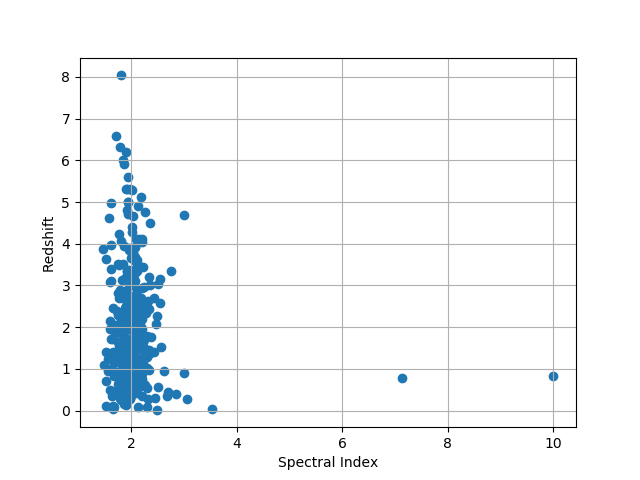

In [63]:
xrt_fig, xrt_axes = plt.subplots(num='XRT data inspection')
def xrt_demo(column1, column2, ommitIndices):
    data_matrix = np.append(
        np.reshape(
            xrt_column_map[column1].values,
            (len(full_df),1)
        ),
        np.reshape(
            xrt_column_map[column2].values,
            (len(full_df),1)
        ),
        axis=1
    ).astype(np.float)
    data_matrix = np.delete(data_matrix, ommitIndices, 0) 
    data_matrix_nonan = data_matrix[~np.isnan(data_matrix).any(axis=1)]
    print("Correlation:", np.corrcoef(data_matrix_nonan,rowvar=False)[0,1])
    print("Data participation: %.02f%%" % (data_matrix_nonan.shape[0]/data_matrix.shape[0]*100))
    
    xrt_axes.cla()
    xrt_axes.set_ylabel(column2)
    xrt_axes.set_xlabel(column1)
    xrt_axes.scatter(data_matrix_nonan[:,0],data_matrix_nonan[:,1])
    xrt_axes.grid()
    xrt_fig.show()
    
xrt_column1_selector = widgets.Dropdown(
    options = xrt_column_names,
    value = 'Spectral Index',
    description = 'Column 1:',
    disabled = False
)

xrt_column2_selector = widgets.Dropdown(
    options = xrt_column_names,
    value = 'Redshift',
    description = 'Column 2:',
    disabled = False
)

xrt_ommission_selector = widgets.SelectMultiple(
    options = list(range(len(full_df))),
    value = [],
    #rows = 10,
    description = 'Ommit points',
    disabled = False
)

xrt_interactive_out=widgets.interactive_output(
    xrt_demo,
    {
        'column1':xrt_column1_selector,
        'column2':xrt_column2_selector,
        'ommitIndices':xrt_ommission_selector
    }
)

xrt_demo_layout = widgets.VBox([
    xrt_interactive_out,
    widgets.HBox([
        xrt_column1_selector,
        xrt_column2_selector
    ]),
    xrt_ommission_selector
])

display(xrt_demo_layout)

## Color indices from UVOT data

In [64]:
uvot_filter_map={
    'V' : (full_df['V_lo']+full_df['V_hi'])/2,
    'V (high)' : full_df['V_hi'],
    'V (low)' : full_df['V_lo'],
    'B' : (full_df['B_lo']+full_df['B_hi'])/2,
    'B (high)' : full_df['B_hi'],
    'B (low)' : full_df['B_lo'],
    'U' : (full_df['U_lo']+full_df['U_hi'])/2,
    'U (high)' : full_df['U_hi'],
    'U (low)' : full_df['U_lo'],
    'UVW1' : (full_df['UVW1_lo']+full_df['UVW1_hi'])/2,
    'UVW1 (high)' : full_df['UVW1_hi'],
    'UVW1 (low)' : full_df['UVW1_lo'],
    'UVM2' : (full_df['UVM2_lo']+full_df['UVM2_hi'])/2,
    'UVM2 (high)' : full_df['UVM2_hi'],
    'UVM2 (low)' : full_df['UVM2_lo'],
    'UVW2' : (full_df['UVW2_lo']+full_df['UVW2_hi'])/2,
    'UVW2 (high)' : full_df['UVW2_hi'],
    'UVW2 (low)' : full_df['UVW2_lo'],
    'White' : (full_df['WHITE_lo']+full_df['WHITE_hi'])/2,
    'White (high)' : full_df['WHITE_hi'],
    'White (low)' : full_df['WHITE_lo'],
    'null' : pd.Series(np.full(len(full_df),0.))
}

In [65]:
uvot_filter_names = list(uvot_filter_map.keys())

<IPython.core.display.Javascript object>


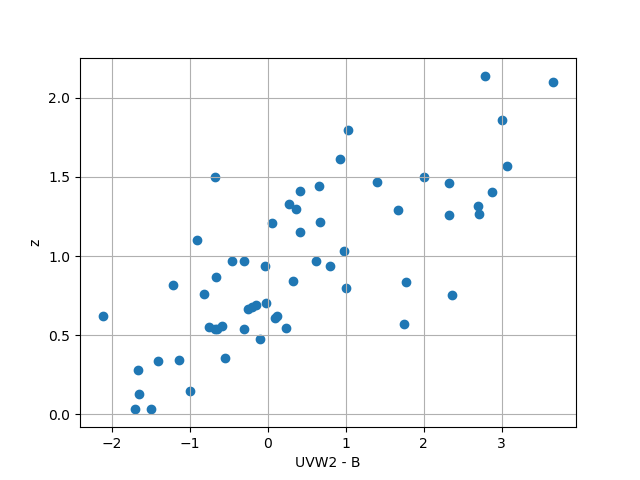

In [66]:
uvot_fig, uvot_axes = plt.subplots(num='UVOT filter inspection')
def uvot_filter_demo(filter1, filter2, ommitIndices):
    data_matrix = np.append(
        np.reshape(
            uvot_filter_map[filter1].values-uvot_filter_map[filter2].values,
            (len(df),1)
        ),
        np.reshape(
            full_df['z'].values,
            (len(df),1)
        ),
        axis=1
    ).astype(np.float)
    data_matrix = np.delete(data_matrix, ommitIndices, 0) 
    data_matrix_nonan = data_matrix[~np.isnan(data_matrix).any(axis=1)]
    print("Correlation:", np.corrcoef(data_matrix_nonan,rowvar=False)[0,1])
    print("Data participation: %.02f%%" % (data_matrix_nonan.shape[0]/data_matrix.shape[0]*100))
    
    uvot_axes.cla()
    uvot_axes.set_ylabel('z')
    xlabel_str = None
    if filter1 == 'null':
        xlabel_str = filter2
    elif filter2 == 'null':
        xlabel_str = filter1
    else:
        xlabel_str = filter1 + ' - ' + filter2
    uvot_axes.set_xlabel(xlabel_str)
    uvot_axes.scatter(data_matrix_nonan[:,0],data_matrix_nonan[:,1])
    uvot_axes.grid()
    uvot_fig.show()
    
filter1_selector = widgets.Dropdown(
    options = uvot_filter_names,
    value = 'UVW2',
    description = 'Filter 1:',
    disabled = False
)

filter2_selector = widgets.Dropdown(
    options = uvot_filter_names,
    value = 'B',
    description = 'Filter 2:',
    disabled = False
)

filter_ommission_selector = widgets.SelectMultiple(
    options = list(range(len(df))),
    value = [167],
    #rows = 10,
    description = 'Ommit points',
    disabled = False
)

filter_interactive_out=widgets.interactive_output(
    uvot_filter_demo,
    {
        'filter1':filter1_selector,
        'filter2':filter2_selector,
        'ommitIndices':filter_ommission_selector
    }
)

filter_demo_layout = widgets.VBox([
    filter_interactive_out,
    widgets.HBox([
        filter1_selector,
        filter2_selector
    ]),
    filter_ommission_selector
])

display(filter_demo_layout)

The above widget allows the inspection of various color indices from UVOT data.

A color index is defined as the difference between magnitude values acquired from two given photometric filters.

The default color index in the widget, the $\text{UVW2}-\text{B}$ index, is one that shows strong correlation with $z$ values.

The data point at index `167` is ommitted by default, because it produces an outlier in the $\text{UVW1}-\text{B}$ and $\text{UVM2}-\text{B}$ color indices.

# Final formatting
Make a type-correct, uniform table to work from.

In [67]:
def map_column_from_df_as_type(df,scol,tcol,tp, scale = 1):
    import numbers
    if issubclass(tp,numbers.Number):
        return (tcol, df[scol].values.astype(tp)*scale)
    else:
        return (tcol, df[scol].values.astype(tp))

In [68]:
final_df = pd.DataFrame(OrderedDict([
    map_column_from_df_as_type(full_df,'GRB','GRB',str),
    map_column_from_df_as_type(full_df,'UTC_Time','UTC_Time',np.int64),
    map_column_from_df_as_type(full_df,'BAT_RA_J2000','BAT_RA',np.float),
    map_column_from_df_as_type(full_df,'BAT_Dec_J2000','BAT_Dec',np.float),
    map_column_from_df_as_type(full_df,'BAT_90pc_Error_Radius','BAT_Error_Radius',np.float),
    map_column_from_df_as_type(full_df,'t90_lo','BAT_T90_lo',np.float),
    map_column_from_df_as_type(full_df,'t90_hi','BAT_T90_hi',np.float),
    map_column_from_df_as_type(full_df,'BAT_Fluence_15_150_keV','BAT_Fluence',np.float),
    map_column_from_df_as_type(full_df,'BAT_Fluence_90pc_Error_15_150_keV','BAT_Fluence_Error',np.float),
    map_column_from_df_as_type(full_df,'BAT_1_sec_Peak_Photon_Flux_15_150_keV','BAT_Peak_Photon_Flux',np.float),
    map_column_from_df_as_type(full_df,'BAT_1_sec_Peak_Photon_Flux_90pc_Error_15_150_keV','BAT_Peak_Photon_Flux_Error',np.float),
    map_column_from_df_as_type(full_df,'bat_photon_index_value','BAT_Photon_Index',np.float),
    map_column_from_df_as_type(full_df,'bat_photon_index_model_idx','BAT_Photon_Index_Model_Index',object),
    map_column_from_df_as_type(full_df,'bat_photon_index_error_min','BAT_Photon_Index_Error_Min',np.float),
    map_column_from_df_as_type(full_df,'bat_photon_index_error_max','BAT_Photon_Index_Error_Max',np.float),
    map_column_from_df_as_type(full_df,'xrt_ra','XRT_RA',np.float),
    map_column_from_df_as_type(full_df,'xrt_dec','XRT_Dec',np.float),
    map_column_from_df_as_type(full_df,'XRT_90pc_Error_Radius','XRT_Error_Radius',np.float),
    map_column_from_df_as_type(full_df,'XRT_Time_to_First_Observation','XRT_Time_to_First_Observation',np.float),
    map_column_from_df_as_type(full_df,'XRT_Early_Flux_0d3_10_keV','XRT_Early_Flux',np.float),
    map_column_from_df_as_type(full_df,'XRT_11_Hour_Flux_0d3_10_keV','XRT_11_Hour_Flux',np.float),
    map_column_from_df_as_type(full_df,'XRT_24_Hour_Flux_0d3_10_keV','XRT_24_Hour_Flux',np.float),
    map_column_from_df_as_type(full_df,'XRT_Initial_Temporal_Index','XRT_Initial_Temporal_Index',np.float),
    map_column_from_df_as_type(full_df,'XRT_Spectral_Index_Gamma','XRT_Spectral_Index_Gamma',np.float),
    map_column_from_df_as_type(full_df,'XRT_Column_Density_NH','XRT_Column_Density_NH',np.float),
    map_column_from_df_as_type(full_df,'uvot_ra','UVOT_RA',np.float),
    map_column_from_df_as_type(full_df,'uvot_dec','UVOT_Dec',np.float),
    map_column_from_df_as_type(full_df,'UVOT_90pc_Error_Radius','UVOT_Error_Radius',np.float),
    map_column_from_df_as_type(full_df,'UVOT_Time_to_First_Observation','UVOT_Time_to_First_Observation',np.float),
    map_column_from_df_as_type(full_df,'V_lo','UVOT_V_lo',np.float),
    map_column_from_df_as_type(full_df,'V_hi','UVOT_V_hi',np.float),
    map_column_from_df_as_type(full_df,'B_lo','UVOT_B_lo',np.float),
    map_column_from_df_as_type(full_df,'B_hi','UVOT_B_hi',np.float),
    map_column_from_df_as_type(full_df,'U_lo','UVOT_U_lo',np.float),
    map_column_from_df_as_type(full_df,'U_hi','UVOT_U_hi',np.float),
    map_column_from_df_as_type(full_df,'UVW1_lo','UVOT_UVW1_lo',np.float),
    map_column_from_df_as_type(full_df,'UVW1_hi','UVOT_UVW1_hi',np.float),
    map_column_from_df_as_type(full_df,'UVM2_lo','UVOT_UVM2_lo',np.float),
    map_column_from_df_as_type(full_df,'UVM2_hi','UVOT_UVM2_hi',np.float),
    map_column_from_df_as_type(full_df,'UVW2_lo','UVOT_UVW2_lo',np.float),
    map_column_from_df_as_type(full_df,'UVW2_hi','UVOT_UVW2_hi',np.float),
    map_column_from_df_as_type(full_df,'WHITE_lo','UVOT_White_lo',np.float),
    map_column_from_df_as_type(full_df,'WHITE_hi','UVOT_White_hi',np.float),
    map_column_from_df_as_type(full_df,'WHITE_FC_lo','UVOT_White_FC_lo',np.float),
    map_column_from_df_as_type(full_df,'WHITE_FC_hi','UVOT_White_FC_hi',np.float),
    map_column_from_df_as_type(full_df,'U_FC_lo','UVOT_U_FC_lo',np.float),
    map_column_from_df_as_type(full_df,'U_FC_hi','UVOT_U_FC_hi',np.float),
    map_column_from_df_as_type(full_df,'z','Redshift',np.float),
    map_column_from_df_as_type(full_df,'z_std','Redshift_Error',np.float)
]))

In [69]:
final_df

,GRB,UTC_Time,BAT_RA,BAT_Dec,BAT_Error_Radius,BAT_T90_lo,BAT_T90_hi,BAT_Fluence,BAT_Fluence_Error,BAT_Peak_Photon_Flux,...,UVOT_UVW2_lo,UVOT_UVW2_hi,UVOT_White_lo,UVOT_White_hi,UVOT_White_FC_lo,UVOT_White_FC_hi,UVOT_U_FC_lo,UVOT_U_FC_hi,Redshift,Redshift_Error
0,180404A,1522802735000,83.540,-37.168,1.1,35.200,35.200,13.00,1.00,1.30,...,19.45,19.45,19.34,19.34,NaN,NaN,NaN,NaN,1.000000,0.000000
1,180329B,1522332503000,82.905,-23.694,1.8,210.000,210.000,33.00,3.00,1.40,...,20.20,NaN,17.69,17.69,NaN,NaN,NaN,NaN,1.998000,0.000000
2,180325A,1521942782000,157.416,24.461,1.1,94.100,94.100,65.00,2.00,9.40,...,20.90,NaN,18.48,18.48,NaN,NaN,NaN,NaN,2.249000,0.001000
3,180314A,1520988211000,99.208,-24.530,3.1,51.200,51.200,110.00,4.00,7.90,...,18.75,18.75,17.86,17.86,NaN,NaN,NaN,NaN,1.445000,0.000000
4,180205A,1517804729300,126.819,11.536,1.1,15.500,15.500,10.00,1.00,3.40,...,17.06,17.06,16.33,16.33,NaN,NaN,NaN,NaN,1.409000,0.000000
5,180115A,1515989763000,12.040,-15.632,1.8,40.900,40.900,7.60,1.10,0.60,...,20.20,NaN,17.61,17.61,NaN,NaN,NaN,NaN,2.487000,0.000000
6,171222A,1513959899000,148.273,35.624,1.7,174.800,174.800,19.00,2.00,0.70,...,19.60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.409000,0.000000
7,171205A,1512458443000,167.423,-12.599,1.6,189.400,189.400,36.00,3.00,1.00,...,16.96,16.96,17.70,17.70,NaN,NaN,NaN,NaN,0.036800,0.000000
8,171020A,1508540830000,39.260,15.199,1.8,41.900,41.900,12.00,1.00,0.70,...,20.30,NaN,21.40,NaN,NaN,NaN,NaN,NaN,1.870000,0.000000
9,170903A,1504442947000,254.532,34.985,1.3,29.200,29.200,24.00,2.00,3.90,...,21.80,NaN,21.60,NaN,NaN,NaN,NaN,NaN,0.886000,0.000000


In [70]:
final_df_width = len(final_df.columns)

meta_df = pd.DataFrame(
    np.concatenate(
        (
            np.reshape(final_df.columns.values,(final_df_width,1)),
            np.reshape(np.array([
                None,None,
                'ms','There were timestamps with fractional second entries, hence the ms unix time.',
                'deg',None,
                'deg',None,
                'arcmin',None,
                'sec',None,
                'sec',None,
                '10^-7 erg/cm^2','15-150 keV',
                '10^-7 erg/cm^2','90% error, 15-150 keV',
                'ph/cm^2/sec','15-150 keV',
                'ph/cm^2/sec','90% error, 15-150 keV',
                None,'15-150 keV',
                None,'0: simple power-law, 1: cutoff power-law',
                None,'90% error, 15-150 keV',
                None,'90% error, 15-150 keV',
                'deg',None,
                'deg',None,
                'arcsec',None,
                'sec',None,
                '10^-11 erg/cm^2/s','0.3-10 keV',
                '10^-11 erg/cm^2/s','0.3-10 keV',
                '10^-11 erg/cm^2/s','0.3-10 keV',
                None,None,
                None,None,
                '10^21 cm^-2',None,
                'deg',None,
                'deg',None,
                'arcsec',None,
                'sec',None,
                'mag',None,
                'mag',None,
                'mag',None,
                'mag',None,
                'mag',None,
                'mag',None,
                'mag',None,
                'mag',None,
                'mag',None,
                'mag',None,
                'mag',None,
                'mag',None,
                'mag',None,
                'mag',None,
                'mag',None,
                'mag',None,
                'mag',None,
                'mag',None,
                '1',None,
                '1','Population standard deviation of recorded observations'
            ]), (final_df_width,2))
        ),
        axis=1
    ),
    columns=['column','unit','notes']
)

In [71]:
meta_df

,column,unit,notes
0,GRB,None,None
1,UTC_Time,ms,There were timestamps with fractional second e...
2,BAT_RA,deg,None
3,BAT_Dec,deg,None
4,BAT_Error_Radius,arcmin,None
5,BAT_T90_lo,sec,None
6,BAT_T90_hi,sec,None
7,BAT_Fluence,10^-7 erg/cm^2,15-150 keV
8,BAT_Fluence_Error,10^-7 erg/cm^2,"90% error, 15-150 keV"
9,BAT_Peak_Photon_Flux,ph/cm^2/sec,15-150 keV


## Tab delimited text save

In [72]:
import os
import shutil

In [73]:
os.mkdir('grbz_data')

In [74]:
with open('grbz_data/grbz_clean_final.txt','w') as final_file:
    final_df.to_csv(final_file,sep='\t',na_rep='')

with open('grbz_data/grbz_meta.txt','w') as meta_file:
    meta_df.to_csv(meta_file,sep='\t',na_rep='')

In [75]:
shutil.make_archive('grbz_data', 'gztar', base_dir='grbz_data')

'grbz_data.tar.gz'

In [76]:
shutil.rmtree('grbz_data')

## SQLite3 database save
Useful, because SQLite saves binary data, but can be found in many places.

If SQLite is not available by default, it can be loaded as an external C library.

In [77]:
import sqlite3

In [78]:
conn = sqlite3.connect('grbz_data.db')

In [79]:
final_df_types = dict(final_df.dtypes)

sqlite_type_map = {
    'object' : 'TEXT',
    'int32' : 'INTEGER',
    'int64' : 'INTEGER',
    'float64' : 'REAL'
}

for key, val in final_df_types.items():
    final_df_types[key] = sqlite_type_map[str(val)]

final_df_types['BAT_Photon_Index_Model_Index'] = 'INTEGER'

meta_df_types = dict(zip(list(meta_df.columns),['TEXT']*len(meta_df.columns)))

In [80]:
final_df.to_sql('grbz_clean_final', conn, if_exists='replace', index = False, dtype=final_df_types)

meta_df.to_sql('grbz_meta', conn, if_exists='replace', index = False, dtype=meta_df_types)

In [81]:
conn.close()

In [82]:
import gzip

In [83]:
with open('grbz_data.db','rb') as final_db:
    with gzip.open('grbz_data.db.gz','wb') as final_zip_db:
        shutil.copyfileobj(final_db, final_zip_db)

In [84]:
os.remove('grbz_data.db')

## Pickle save

In [85]:
pd.DataFrame({
    'grbz_clean_final' : [final_df],
    'grbz_meta' : [meta_df]
}).to_pickle('grbz_data.pkl', compression = 'gzip')

## Excel save

In [86]:
writer = pd.ExcelWriter('grbz_data.xlsx')

In [87]:
final_df.to_excel(writer, sheet_name = 'grbz_clean_final', index = False, freeze_panes = (1,0))
meta_df.to_excel(writer, sheet_name = 'grbz_meta', index = False)

In [88]:
writer.save()